In [1]:
from aws_helper_functions import aws_helper_functions
import numpy as np
import pandas as pd
import datetime as dt
from sklearn.neighbors import BallTree
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import shap

from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib as plt
import optuna

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
target = ['yield']
predictors = ['scholar_grade'
              , 'school'
              , 'days_since_offer'
              #, 'uniform_ordered'
              , 'accepted_first_rank'
              , 'had_enrolled_sib'
              , 'commute_time'
              , 'summer_intensive'
              #, 'orientation_rsvp'
              #, 'virtual_event_attended'
              #, 'in_person_event_attended'
              #, 'utm_source_bucketing'
              ]
# Parameters for all variables
# params = {
#     'objective': 'binary',
#     'metric': 'binary_error',
#     'verbosity': -1,
#     'boosting_type': 'gbdt',
#     'seed': 0,
#     'feature_pre_filter': False,
#     'lambda_l1': 9.750895762102681,
#     'lambda_l2': 8.658575746243313,
#     'num_leaves': 8,
#     'feature_fraction': 0.8999999999999999,
#     'bagging_fraction': 0.9325400996589253,
#     'bagging_freq': 1,
#     'min_child_samples': 25
# }
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'seed': 0,
    'feature_pre_filter': False,
    'lambda_l1': 4.1741221405371745,
    'lambda_l2': 5.786942563087464,
    'num_leaves': 2,
    'feature_fraction': 0.4,
    'bagging_fraction': 0.9907131764658781,
    'bagging_freq': 3,
    'min_child_samples': 100
}

In [3]:
def set_dates(as_of_date):
    todays_date = as_of_date
    last_years_date = (dt.datetime.strptime(as_of_date,'%Y-%m-%d') - dt.timedelta(365)).strftime('%Y-%m-%d')
    return last_years_date, todays_date

def read_data(as_of_date, query_name='',query_dir='',local_mode=''):
    query_file = query_dir + query_name
    query = open(query_file).read()
    query = query.format(date=as_of_date)
    basetable = aws_helper_functions.read_from_redshift(query, local_mode=local_mode)
    return basetable

def _clean_data(basetable):
    dat = pd.DataFrame(basetable)
    dat['school'] = dat['accepted_school'].astype('category')
    dat['scholar_grade'] = dat['grade'].astype('category')
    dat['latitude'] = dat['students_home__latitude__s']
    dat['longitude'] = dat['students_home__longitude__s']
    try:
        dat['utm_source_bucketing'] = dat['utm_source_bucketing'].astype('category')
    except: 
        pass
    return dat

def _retrieve_nearest_census_tract_numbers(df, local_mode=''):
    # retrive census tract information from redshift
    df_census = aws_helper_functions.read_from_redshift('SELECT * FROM raw_data_science.raw_commute_census_tracts_lat_long', local_mode=local_mode)
    # Create a BallTree for the census tract latitudes and longitudes
    tree = BallTree(df_census[['lat_orig', 'long_orig']].values, leaf_size=40)
    
    #drop rows in df where students_home__latitude__s or students_home__longitude__s is null
    #df = df.dropna(subset=['latitude', 'longitude'])
    df['latitude'] = np.where(df['latitude'].isna()==True, 40.776676, df['latitude'])
    df['longitude'] = np.where(df['longitude'].isna()==True, -73.971321, df['longitude'])
    
    distances, indices = tree.query(df[['latitude', 'longitude']].values, k=1)
    df.loc[:, 'boro_int'] = df_census.loc[indices.flatten(), 'boro_int'].values.copy()
    df.loc[:, 'census_tract_int'] = df_census.loc[indices.flatten(), 'census_tract_int'].values.copy()
    return df

def _get_commute_time(df, local_mode=''):
    #retrieve school-census tract commute times from redshift
    df_commutes = aws_helper_functions.read_from_redshift('SELECT * FROM raw_data_science.raw_commute_census_tracts_to_schools', local_mode=local_mode)
    
    schools = _get_schools()
    df_commutes = _replace_with_keys(df_commutes, 'school', schools)
    #set df_commutes.time_walking_min, time_transit_min, and time_driving_min to numeric
    df_commutes['time_walking_min'] = pd.to_numeric(df_commutes['time_walking_min'], errors='coerce')
    df_commutes['time_transit_min'] = pd.to_numeric(df_commutes['time_transit_min'], errors='coerce')
    df_commutes['time_driving_min'] = pd.to_numeric(df_commutes['time_driving_min'], errors='coerce')
    
    df_commutes['commute_time'] = df_commutes[['time_walking_min', 'time_transit_min']].min(axis=1)
    df_commutes = df_commutes[['boro_int', 'census_tract_int', 'school', 'commute_time']]
    
    df = df.merge(df_commutes, how='left', on=['boro_int', 'census_tract_int', 'school'])
    df['commute_time'] = np.where(df['commute_time']>120,30,df['commute_time'])
    df['commute_time'] = np.where(df['commute_time'].isnull(),30,df['commute_time'])
    return df

def _get_schools():
    schools = {
        'SA Bed-Stuy 2': 'BED-STUY2',
        'SA Bed-Stuy': 'BED-STUY2',
        'SA Bed-Stuy Middle School': 'BED-STUY_MIDDLE_SCHOOL',
        'SA Bensonhurst': 'BENSONHURST',
        'SA Bergen Beach':'BERGEN_BEACH',
        'SA Bronx 1 Middle School': 'BRONX1',
        'SA Bronx 1': 'BRONX1',
        'SA Bronx Middle School': 'BRONX_MIDDLE_SCHOOL',
        'SA Bronx 2': 'BRONX2',
        'SA Bronx 2 Middle School': 'BRONX2_MIDDLE_SCHOOL',
        'SA Bronx 3': 'BRONX3',
        'SA Bronx 4': 'BRONX4',
        'SA Bronx 5': 'BRONX5',
        'SA Bronx 5 Upper': 'BRONX5',
        'SA Bronx 5 Lower': 'BRONX5',
        'SA Bushwick': 'BUSHWICK',
        'SA Cobble Hill': 'COBBLE_HILL',
        'SA Crown Heights': 'CROWN_HEIGHTS',
        'SA Ditmas Park Middle School': 'DITMAS_PARK_MIDDLE_SCHOOL',
        'SA East Flatbush Middle School': 'EAST_FLATBUSH_MIDDLE_SCHOOL',
        'SA Far Rockaway': 'FAR_ROCKAWAY',
        'SA Far Rockaway Middle School': 'FAR_ROCKAWAY_MIDDLE_SCHOOL',
        'SA Flatbush': 'FLATBUSH',
        'SA Hamilton Heights Middle School': 'HARLEM6',
        'SA Harlem 1': 'HARLEM1',
        'SA Harlem 2': 'HARLEM2',
        'SA Harlem 3': 'HARLEM3',
        'SA Harlem 4': 'HARLEM4',
        'SA Harlem 5': 'HARLEM5',
        'SA Harlem 6': 'HARLEM6',
        'SA Harlem East': 'HARLEM_EAST',
        'SA Harlem East Middle School': 'HARLEM_EAST',
        'SA Harlem North Central': 'HARLEM_NORTH_CENTRAL',
        'SA Harlem North Central Middle School': 'HARLEM_NORTH_CENTRAL',
        'SA Harlem West': 'HARLEM_WEST',
        'SA Harlem West Middle School': 'HARLEM_WEST',
        'SA Harlem North West': 'HARLEM_NORTH_WEST',
        'SA Harlem North West Middle School': 'HARLEM_NORTH_WEST',
        'SA Hells Kitchen': 'HELLS_KITCHEN',
        'SA Hell\'s Kitchen': 'HELLS_KITCHEN',
        'SA High School of the Liberal Arts - Manhattan': 'HIGH_SCHOOL_OF_THE_LIBERAL_ARTS_-_MANHATTAN',
        'SA High School of the Liberal Arts-Manhattan': 'HIGH_SCHOOL_OF_THE_LIBERAL_ARTS_-_MANHATTAN',
        'SA High School of the Liberal Arts - Harlem': 'HIGH_SCHOOL_OF_THE_LIBERAL_ARTS_-_HARLEM',
        'SA High School of the Liberal Arts-Harlem': 'HIGH_SCHOOL_OF_THE_LIBERAL_ARTS_-_HARLEM',
        'SA High School of the Liberal Arts - Brooklyn': 'HIGH_SCHOOL_OF_THE_LIBERAL_ARTS_-_BROOKLYN',
        'SA High School of the Liberal Arts-Brooklyn': 'HIGH_SCHOOL_OF_THE_LIBERAL_ARTS_-_BROOKLYN',
        'SA Hudson Yards': 'HUDSON_YARDS',
        'SA Hudson Yards Middle School': 'HUDSON_YARDS_MIDDLE_SCHOOL',
        'SA Kingsbridge Heights': 'KINGSBRIDGE_HEIGHTS',
        'SA Lafayette Middle School': 'LAFAYETTE_MIDDLE_SCHOOL',
        'SA Midtown West Middle School': 'MIDTOWN_WEST',
        'SA Myrtle Middle School': 'MYRTLE_MIDDLE_SCHOOL',
        'SA Norwood': 'NORWOOD',
        'SA Ozone Park Middle School': 'OZONE_PARK_MIDDLE_SCHOOL',
        'SA Prospect Heights': 'PROSPECT_HEIGHTS',
        'SA Queens Village': 'QUEENS_VILLAGE',
        'SA Rosedale': 'ROSEDALE',
        'SA Rockaway Park Middle School': 'ROCKAWAY_PARK_MIDDLE_SCHOOL',
        'SA South Jamaica': 'SOUTH_JAMAICA',
        'SA Sheepshead Bay': 'SHEEPSHEAD_BAY',
        'SA Springfield Gardens Middle School': 'SPRINGFIELD_GARDENS',
        'SA Springfield Gardens MS': 'SPRINGFIELD_GARDENS',
        'SA Springfield Gardens': 'SPRINGFIELD_GARDENS',
        'SA Union Square': 'UNION_SQUARE',
        'SA Upper West': 'UPPER_WEST',
        'SA Washington Heights': 'WASHINGTON_HEIGHTS',
        'SA Williamsburg': 'WILLIAMSBURG',
        'SA Unionport Middle School': '2169_BLACKROCK_AVE,_THE_BRONX,_NY_10472',
        'SA Williamsbridge': '760_E_GUN_HILL_RD,_THE_BRONX,_NY_10467'
        }
    return schools

def _replace_with_keys(df, column, dictionary):
    new_df = pd.DataFrame()
    for key, value in dictionary.items():
        temp_df = df[df[column] == value].copy()
        temp_df[column] = key
        new_df = pd.concat([new_df, temp_df])
    return new_df

def _middle_school_buckets(df):
    df['school'] = np.where(df['school']=='SA Ditmas Park Middle School', 'Non-Ozone MS', df['school'])
    df['school'] = np.where(df['school']=='SA Harlem West', 'Non-Ozone MS', df['school'])
    df['school'] = np.where(df['school']=='SA Hamilton Heights Middle School', 'Non-Ozone MS', df['school'])
    df['school'] = np.where(df['school']=='SA Hudson Yards Middle School', 'Non-Ozone MS', df['school'])
    df['school'] = np.where(df['school']=='SA Bronx Middle School', 'Non-Ozone MS', df['school'])
    df['school'] = np.where(df['school']=='SA Bronx 2 Middle School', 'Non-Ozone MS', df['school'])
    df['school'] = np.where(df['school']=='SA Harlem North Central', 'Non-Ozone MS', df['school'])
    df['school'] = np.where(df['school']=='SA Unionport Middle School', 'Non-Ozone MS', df['school'])
    df['school'] = np.where(df['school']=='SA Harlem Central', 'Non-Ozone MS', df['school'])
    df['school'] = np.where(df['school']=='SA Bed-Stuy Middle School', 'Non-Ozone MS', df['school'])
    df['school'] = np.where(df['school']=='SA Bronx 1 Middle School', 'Non-Ozone MS', df['school'])
    df['school'] = np.where(df['school']=='SA Harlem East', 'Non-Ozone MS', df['school'])
    df['school'] = np.where(df['school']=='SA Midtown West Middle School', 'Non-Ozone MS', df['school'])
    df['school'] = np.where(df['school']=='SA Springfield Gardens MS', 'Non-Ozone MS', df['school'])
    df['school'] = np.where(df['school']=='SA Rockaway Park Middle School', 'Non-Ozone MS', df['school'])
    df['school'] = np.where(df['school']=='SA Harlem North West', 'Non-Ozone MS', df['school'])
    df['school'] = np.where(df['school']=='SA Myrtle Middle School', 'Non-Ozone MS', df['school'])
    df['school'] = np.where(df['school']=='SA Lafayette Middle School', 'Non-Ozone MS', df['school'])
    df['school'] = np.where(df['school']=='SA East Flatbush Middle School', 'Non-Ozone MS', df['school'])
    return df

def get_data(as_of_date='',query_dir='',query_name='',local_mode=''):
    raw_data = read_data(as_of_date=as_of_date,query_dir=query_dir,query_name=query_name,local_mode=local_mode)
    cleaned_data = _clean_data(raw_data)
    census_tract_data = _retrieve_nearest_census_tract_numbers(cleaned_data,local_mode=local_mode)
    commute_time_data = _get_commute_time(census_tract_data,local_mode=local_mode)
    bucketed_data = _middle_school_buckets(commute_time_data)
    return bucketed_data

def setup_training_data(df, predictors, target):
    X = df[predictors]
    Y = df[target]
    X['school'] = X['school'].astype('category')
    X['scholar_grade'] = X['scholar_grade'].astype('category')
    return X, Y

def setup_evaluation_data(df, predictors, target):
    X_eval = df[predictors]
    X_eval['school'] = X_eval['school'].astype('category')
    X_eval['scholar_grade'] = X_eval['scholar_grade'].astype('category')
    return X_eval

def test_train_split(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=0)
    return X_train, X_test, y_train, y_test

def _model_fit(X_train, X_test, y_train, y_test):
    lgbm = lgb.LGBMClassifier(**params)
    lgbm.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)],eval_metric='auc')
    return lgbm

def model_predict(X_eval, model):
    y_pred = model.predict_proba(X_eval)[:, 1]
    results = X_eval
    results['yield_probability'] = y_pred
    return results

def _get_shap_values(results, predictors, model): 
    # Explain LGBM predictions with Shap
    X = results[predictors]
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    series_shap = pd.DataFrame(np.abs(shap_values),columns = X.columns).apply(lambda x: x.nlargest(3).index.tolist(), axis=1)
    df_shap = pd.DataFrame(np.stack(series_shap),columns = ['first_driver','second_driver','third_driver'])
    results['first_driver'] = df_shap['first_driver']
    results['second_driver'] = df_shap['second_driver']
    results['third_driver'] = df_shap['third_driver']
    return results

def _clean_output(df, results):
    df = pd.DataFrame(df)
    df['yield_probability'] = results['yield_probability']
    df['yield_bucket'] = '0-10%'
    df['yield_bucket'] = np.where(df['yield_probability']>0.1,'10-20%',df['yield_bucket'])
    df['yield_bucket'] = np.where(df['yield_probability']>0.2,'20-40%',df['yield_bucket'])
    df['yield_bucket'] = np.where(df['yield_probability']>0.4,'40-60%',df['yield_bucket'])
    df['yield_bucket'] = np.where(df['yield_probability']>0.6,'60-80%',df['yield_bucket'])
    df['yield_bucket'] = np.where(df['yield_probability']>0.8,'>80%',df['yield_bucket'])
    df['first_driver'] = results['first_driver']
    df['second_driver'] = results['second_driver']
    df['third_driver'] = results['third_driver']
    df['future_accepted_school__school_name'] = df['school']
    df['future_grade'] = df['grade']
    df['address__c'] = np.nan
    df['verified_parent'] = np.nan
    df['ds'] = np.nan
    df['probability_attending_5_days'] = df['yield_probability']
    df = df[['individual__c', 'round_app_id', 'round_app_name',
                                   'application_date', 'future_accepted_school__school_name', 'future_grade', 
                                   'students_home__latitude__s', 'students_home__longitude__s', 'address__c', 'city__c',
                                   'zip_code__c', 'gender__c', 'how_did_you_hear_about_us__c', 'parent_id',
                                   'parent_uuid', 'preference_structure_verbiage', 'boro_int', 'census_tract_int', 'commute_time',
                                   'program_rank', 'verified_parent', 'probability_attending_5_days', 
                                   'days_since_offer', 'had_enrolled_sib', 'summer_intensive',
                                   'first_driver', 'second_driver','third_driver','yield_bucket', 
                                   'ds']]
    return df

def make_predictions(run_date=dt.date.today().strftime('%Y-%m-%d'), query_dir='', local_mode=''):
    train_date, eval_date = set_dates(run_date)
    df_train = get_data(as_of_date=train_date,query_dir=query_dir,query_name='train_basetable.sql',local_mode=local_mode)

    X, Y =  setup_training_data(df_train, predictors, target)
    X_train, X_test, y_train, y_test =  test_train_split(X, Y)
    lgbm =  _model_fit(X_train, X_test, y_train, y_test)

    df = get_data(as_of_date=eval_date,query_dir=query_dir,query_name='eval_basetable.sql',local_mode=local_mode)
    X_eval =  setup_evaluation_data(df, predictors, target)
    results =  model_predict(X_eval, lgbm)
    results['yield_probability'] = np.where(results['scholar_grade']=='4', results['yield_probability']/2,results['yield_probability'])
    results_shap =  _get_shap_values(results, predictors, lgbm)
    cleaned_results =  _clean_output(df, results_shap)
    return cleaned_results

def _performance_check(X_train, y_train, X_test, y_test, model):
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    print('Mean probability: ',np.mean(y_pred))
    print('Min probability: ',min(y_pred))
    print('Max probability: ',max(y_pred))
    sns.kdeplot(y_pred)
    plt.pyplot.show()
    color_map = 'Blues'
    cm = confusion_matrix(y_pred, y_test)
    cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive: 1', 'Actual Negative: 0'],index=['Predict Positive: 1', 'Predict Negative: 0'])
    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap=color_map)
    plt.pyplot.show()
    test_report = classification_report(y_pred, y_test, output_dict=True)
    sns.heatmap(pd.DataFrame(test_report).iloc[:-1, :].T, annot=True, cmap=color_map)
    plt.pyplot.show()
    lgb.plot_importance(model, color=[plt.pyplot.get_cmap(color_map)(i) for i in np.linspace(0,1,len(predictors))],grid=False,importance_type='split',height=0.8)

In [4]:
run_date = '2024-04-10'
local_mode = True
query_dir = '/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/'

train_date, eval_date = set_dates(run_date)
df_train = get_data(as_of_date=train_date,query_dir=query_dir,query_name='train_basetable.sql',local_mode=local_mode)

X, Y =  setup_training_data(df_train, predictors, target)
X_train, X_test, y_train, y_test =  test_train_split(X, Y)
lgbm =  _model_fit(X_train, X_test, y_train, y_test)

In [15]:
len(df_train)

12129

In [13]:
df_train.to_csv('yield_train_04-11.csv',index=False)

In [7]:
print('Total offers: ', len(df_train))
print('Yields: ', sum(df_train['yield']))
print('Yield rate: ',sum(df_train['yield'])/len(df_train))

Total offers:  12129
Yields:  3189
Yield rate:  0.26292357160524366


In [11]:
print('Total offers: ', len(cleaned_results))
print('Yields: ', sum(cleaned_results['probability_attending_5_days']))
print('Yield rate: ',sum(cleaned_results['probability_attending_5_days'])/len(cleaned_results))

Total offers:  14869
Yields:  3769.3350637736385
Yield rate:  0.25350292983883504


Mean probability:  0.08572370590174744
Min probability:  0
Max probability:  1


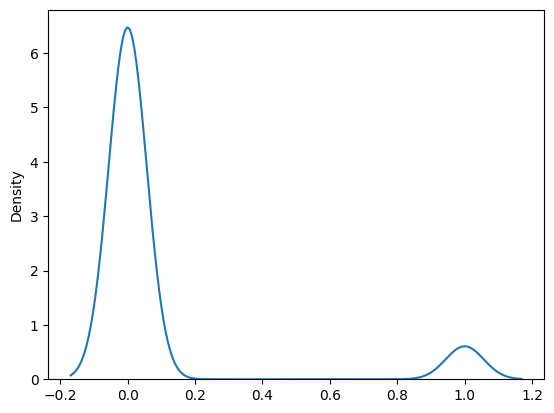

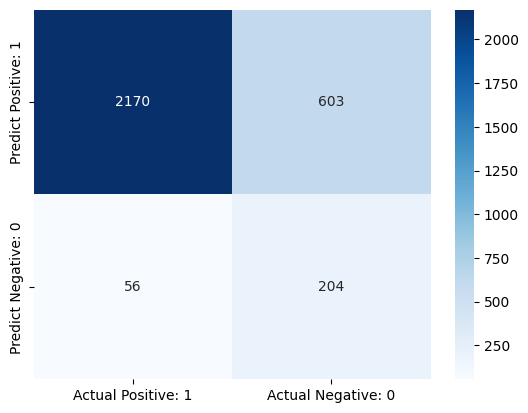

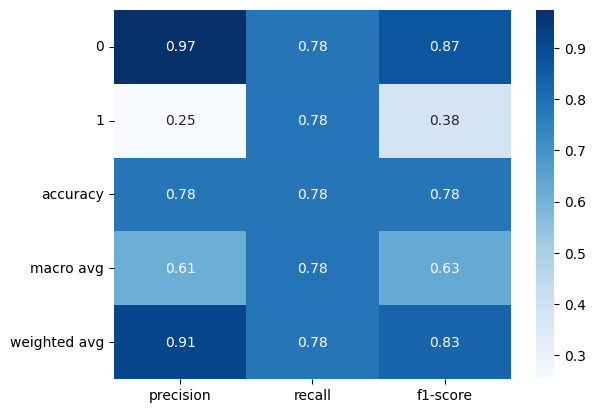

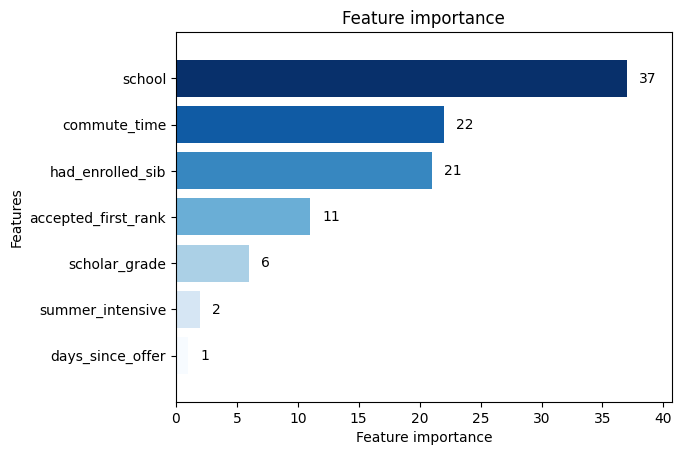

In [13]:
_performance_check(X_train, y_train, X_test, y_test, lgbm)

In [8]:
df = get_data(as_of_date=eval_date,query_dir=query_dir,query_name='eval_basetable.sql',local_mode=local_mode)
X_eval =  setup_evaluation_data(df, predictors, target)
results =  model_predict(X_eval, lgbm)
results['yield_probability'] = np.where(results['scholar_grade']=='4', results['yield_probability']/2,results['yield_probability'])
results_shap =  _get_shap_values(results, predictors, lgbm)
cleaned_results =  _clean_output(df, results_shap)

In [9]:
cleaned_results

,individual__c,round_app_id,round_app_name,application_date,future_accepted_school__school_name,future_grade,students_home__latitude__s,students_home__longitude__s,address__c,city__c,...,verified_parent,probability_attending_5_days,days_since_offer,had_enrolled_sib,summer_intensive,first_driver,second_driver,third_driver,yield_bucket,ds
0,None,a0yR7000000BUNlIAO,A-00045515,2023-12-05,SA Washington Heights,5,40.765947,-73.961996,NaN,None,...,NaN,0.101980,6,0,1,school,commute_time,had_enrolled_sib,10-20%,NaN
1,None,a0yR7000000MV1xIAG,A-00047705,2024-01-03,SA Washington Heights,K,NaN,NaN,NaN,None,...,NaN,0.128397,6,0,0,school,commute_time,had_enrolled_sib,10-20%,NaN
2,None,a0yR7000000Oj0nIAC,A-00048211,2024-01-08,SA Harlem 2,K,40.811531,-73.935959,NaN,None,...,NaN,0.295589,6,0,0,commute_time,had_enrolled_sib,scholar_grade,20-40%,NaN
3,None,a0yR700000139vpIAA,A-00059165,2024-03-12,SA Harlem 2,K,40.844422,-73.908771,NaN,None,...,NaN,0.219248,6,0,0,had_enrolled_sib,commute_time,scholar_grade,20-40%,NaN
4,None,a0yR7000000tfQjIAI,A-00057206,2024-02-29,SA Harlem 4,3,40.798569,-73.960022,NaN,None,...,NaN,0.340551,6,0,0,commute_time,school,had_enrolled_sib,20-40%,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14864,None,a0yR70000018YlVIAU,A-00060549,2024-03-20,SA Harlem 4,1,40.819329,-73.956086,NaN,None,...,NaN,0.263201,6,0,0,school,had_enrolled_sib,commute_time,20-40%,NaN
14865,None,a0y5f000003SaGdAAK,A-00041227,2023-10-11,SA Harlem 5,1,40.819794,-73.944926,NaN,None,...,NaN,0.320961,6,0,0,commute_time,had_enrolled_sib,school,20-40%,NaN
14866,None,a0yR7000000BZldIAG,A-00045628,2023-12-05,SA Prospect Heights,K,40.686483,-73.949460,NaN,None,...,NaN,0.275077,6,0,0,commute_time,had_enrolled_sib,scholar_grade,20-40%,NaN
14867,None,a0y5f000003T4KeAAK,A-00042524,2023-10-22,SA Sheepshead Bay,K,40.612015,-73.949254,NaN,None,...,NaN,0.279971,6,0,0,commute_time,had_enrolled_sib,scholar_grade,20-40%,NaN


In [58]:
rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=0)
study_tuner = optuna.create_study(direction='minimize')
dtrain = optuna.integration.lightgbm.Dataset(X_train, label=y_train)
optuna.logging.set_verbosity(optuna.logging.WARNING) 
    # Set tuning params
params_tuner = {
        'objective': 'binary',
        'metric': 'binary_error',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'seed': 0
        }
    # Run optuna LightGBMTunerCV tuning of LightGBM with cross-validation
tuner = optuna.integration.lightgbm.LightGBMTunerCV(params_tuner, 
                                dtrain, 
                                study=study_tuner,
                                categorical_feature='auto',
                                seed = 0,
                                folds=rkf
                            )
tuner.run()
print('Best params: ')
for key, value in tuner.best_params.items():
    print("    {}: {}".format(key, value))
print('Best score: ', tuner.best_score)

[I 2024-04-09 13:01:36,845] A new study created in memory with name: no-name-ae22ac2f-e5f8-4aeb-90ee-04273489618b
min_child_samples, val_score: 0.219404: 100%|##########| 5/5 [03:57<00:00, 47.47s/it]

Best params: 
    objective: binary
    metric: binary_error
    verbosity: -1
    boosting_type: gbdt
    seed: 0
    feature_pre_filter: False
    lambda_l1: 4.1741221405371745
    lambda_l2: 5.786942563087464
    num_leaves: 2
    feature_fraction: 0.4
    bagging_fraction: 0.9907131764658781
    bagging_freq: 3
    min_child_samples: 100
Best score:  0.21940386126524739
